# Satellite Analysis
Classic GOES 16 Infrared Satelite Analysis with colormap.

This example uses example data from the GOES 16 to plot the IR imagery
with a colortable for the most current data accessed using Siphon.
The plotting is completed with the help of MetPy and geographic plotting
using Cartopy for a CONUS view.

In [7]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import colortables
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
import xarray as xr
%matplotlib inline
plt.style.use('dark_background')

## Grab Data
The following code will access data from a THREDDS server at Unidata
that contains GOES 16 data. Through siphon we can access the data using an
xarray format.

In [2]:
# Set channel number (1-16)
# Channels 1-6 (Visible)
# Channel 7 (daylight/nighttime band)
# Channels 8-10 (Water Vapor)
# Channels 11-16 (IR)

# Have computer give current time
date = datetime.utcnow()

# Select a channel for viewing
channel = 14
sector = 'CONUS'

#https://thredds.ucar.edu/thredds/catalog/satellite/goes16/GOES16/CONUS/Channel14/current/catalog.html
base_url = 'http://thredds.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/'
date_portion = '{0}/Channel{1:02d}/{2:%Y%m%d}/'.format(sector, channel, date)
current_goes16 = TDSCatalog(base_url+date_portion+'catalog.xml')

# Use the latest file through the 0 index value
latest_file = current_goes16.datasets[0]

# Actually grab the data
ds = latest_file.remote_access(use_xarray=True)

In [3]:
# Use MetPy parsing to help gather projection information
sat_data = ds.metpy.parse_cf('Sectorized_CMI')

In [4]:
# Set projection based on info from file
proj = sat_data.metpy.cartopy_crs

# Get projection x and y data for plotting
x = sat_data.metpy.x
y = sat_data.metpy.y

# Have file tell me the central wavelength of the data
wavelength = ds.central_wavelength

## Plot Figure
The following code will plot the satellite image channel
using a colormap from MetPy

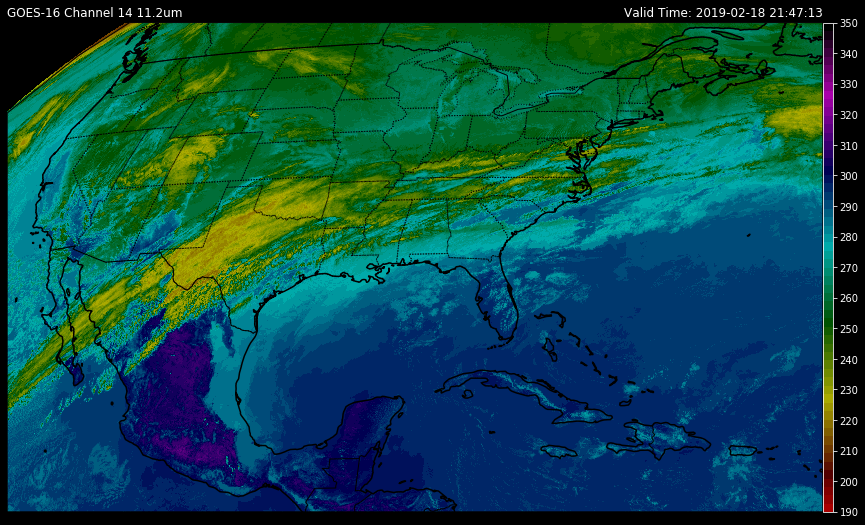

In [8]:
# Start the figre
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111, projection=proj)

# Use a colortable/colormap available from MetPy
ir_norm, ir_cmap = colortables.get_with_range('ir_drgb_r', 190, 350)

# Plot the data using imshow
im = ax.imshow(sat_data, origin='upper', cmap=ir_cmap, norm=ir_norm,
               extent=(x.min(), x.max(), y.min(), y.max()))
plt.colorbar(im, pad=0, aspect=50, ticks=range(190,351,10))

# Add country borders and states (use your favorite linestyle!)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1.5,
               edgecolor='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=1,
               edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':',
               edgecolor='black')

# Add appropriate titles
timestamp = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
plt.title('Valid Time: {}'.format(timestamp), loc='right')
plt.title('GOES-16 Channel {} {:.1f}um'.format(channel, wavelength), loc='left')

plt.savefig('IR_Satellite.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()